In [1]:
#容器持久化python lib地址，因为使用的镜像是conda管理环境，目前没找到方法添加第三方lib路径到conda环境中
#安装命令
#pip install --install-option="--prefix=/jupyter-datascience-notebook/packages" --ignore-installed <your-package>
import sys
sys.path.append('/jupyter-datascience-notebook/packages/lib/python3.6/site-packages')

# GIT地址  https://github.com/jussker/OCR_example

In [2]:
# import numpy
# import scipy
# import matplotlib
# import PIL
# import OpenGL
# import pydot
# import simplejson
# import sqlite3
# import cherrypy

In [52]:
from PIL import Image
from scipy.ndimage import filters
from numpy import ndarray,array,zeros,argsort,sort,isnan,nonzero
import matplotlib.pyplot as pyplot
import logging
import sys

# Get root logger (all other loggers will be derived from this logger's
# properties)
logger = logging.getLogger()


In [4]:
def compute_harris_response(im, sigma=3):
#         sigma : scalar or sequence of scalars
#         Standard deviation for Gaussian kernel. The standard
#         deviations of the Gaussian filter are given for each axis as a
#         sequence, or as a single number, in which case it is equal for
#         all axes.
    """ 在一幅灰度图像中，对每个像素计算 Harris 角点检测器响应函数"""
    # 计算导数
    imx = zeros(im.shape)
    # x,y 方向的sigma 被设置成了一样的。尚不清楚原因，演示代码的原因？？
    filters.gaussian_filter(im, (sigma, sigma), (0, 1), imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (1, 0), imy)
    
    # 计算Harris 矩阵的分量
    Wxx = filters.gaussian_filter(imx * imx, sigma)
    Wxy = filters.gaussian_filter(imx * imy, sigma)
    Wyy = filters.gaussian_filter(imy * imy, sigma)
    
    # 计算特征值和迹
    Wdet = Wxx * Wyy - Wxy * 2
    Wtr = Wxx + Wyy
    
    return Wdet / Wtr

In [28]:
def get_harris_points(harrisim, min_dist=10, threshold=0.1):
    """ 从 一幅 Harris 响应 图像 中 返回 角 点。 min_ dist 为 分割 角 点 和 图像 边界 的 最少 像素 数目"""
    # 寻找高于阈值的候选角点
    # 增加nan值过滤，存在nan值，可能是由于x/y方向没有导导致的？？?
    corner_threshold = harrisim[isnan(harrisim) == False].max() * threshold
    
    # 将高斯模糊后的图像，进行阈值过滤转为布尔数字，在转为数值0/1的二值数组 
    harrisim_t = (harrisim > corner_threshold) * 1
    
    # 得到候选点的坐标，大于阈值的点所在位置的值为1，零-不感兴趣的被过滤
    # numpy.nonzero 返回非0值的索引
    coords = array(harrisim_t.nonzero()).T
    
    # 以及它们的Harris响应值
    # 根据上述兴趣点索引，将原始高斯模糊后的值取出来
    candidate_values = [harrisim[c[0], c[1]] for c in coords]
    
    # 对候选点按照Harris响应值进行排序，返回索引,默认降序
    # 即最感兴趣的点出现在最前面
    index = argsort(candidate_values)
    
    # 将可行点的位置保存到数组中
    allowed_locations = zeros(harrisim.shape)
    # 剔除了min_dist个像素的边距，并将边距内的值置为1
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    
    # 按照min_distance 原则,选择最佳Harris点
    filtered_coords = []
    for i in index:
        # 按照排序后的顺序提取兴趣点
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            # 提取兴趣点后，将兴趣点周围min_dist单位区域置为不感兴趣，值为0
            allowed_locations[(coords[i, 0] - min_dist):(coords[i, 0] + min_dist),
                              (coords[i, 1] - min_dist):(coords[i, 1] + min_dist)
                             ] = 0
    return filtered_coords 
    

In [55]:
def plot_harris_points(image, filtered_coords):
    """绘制图像中检测到的角点"""
    # 只有绘图功能而已，不属于算法部分
    pyplot.figure(figsize=(50,50))
    pyplot.gray()
    pyplot.imshow(image)
    pyplot.plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], 'o')
    pyplot.axis('off')
    pyplot.show()
    

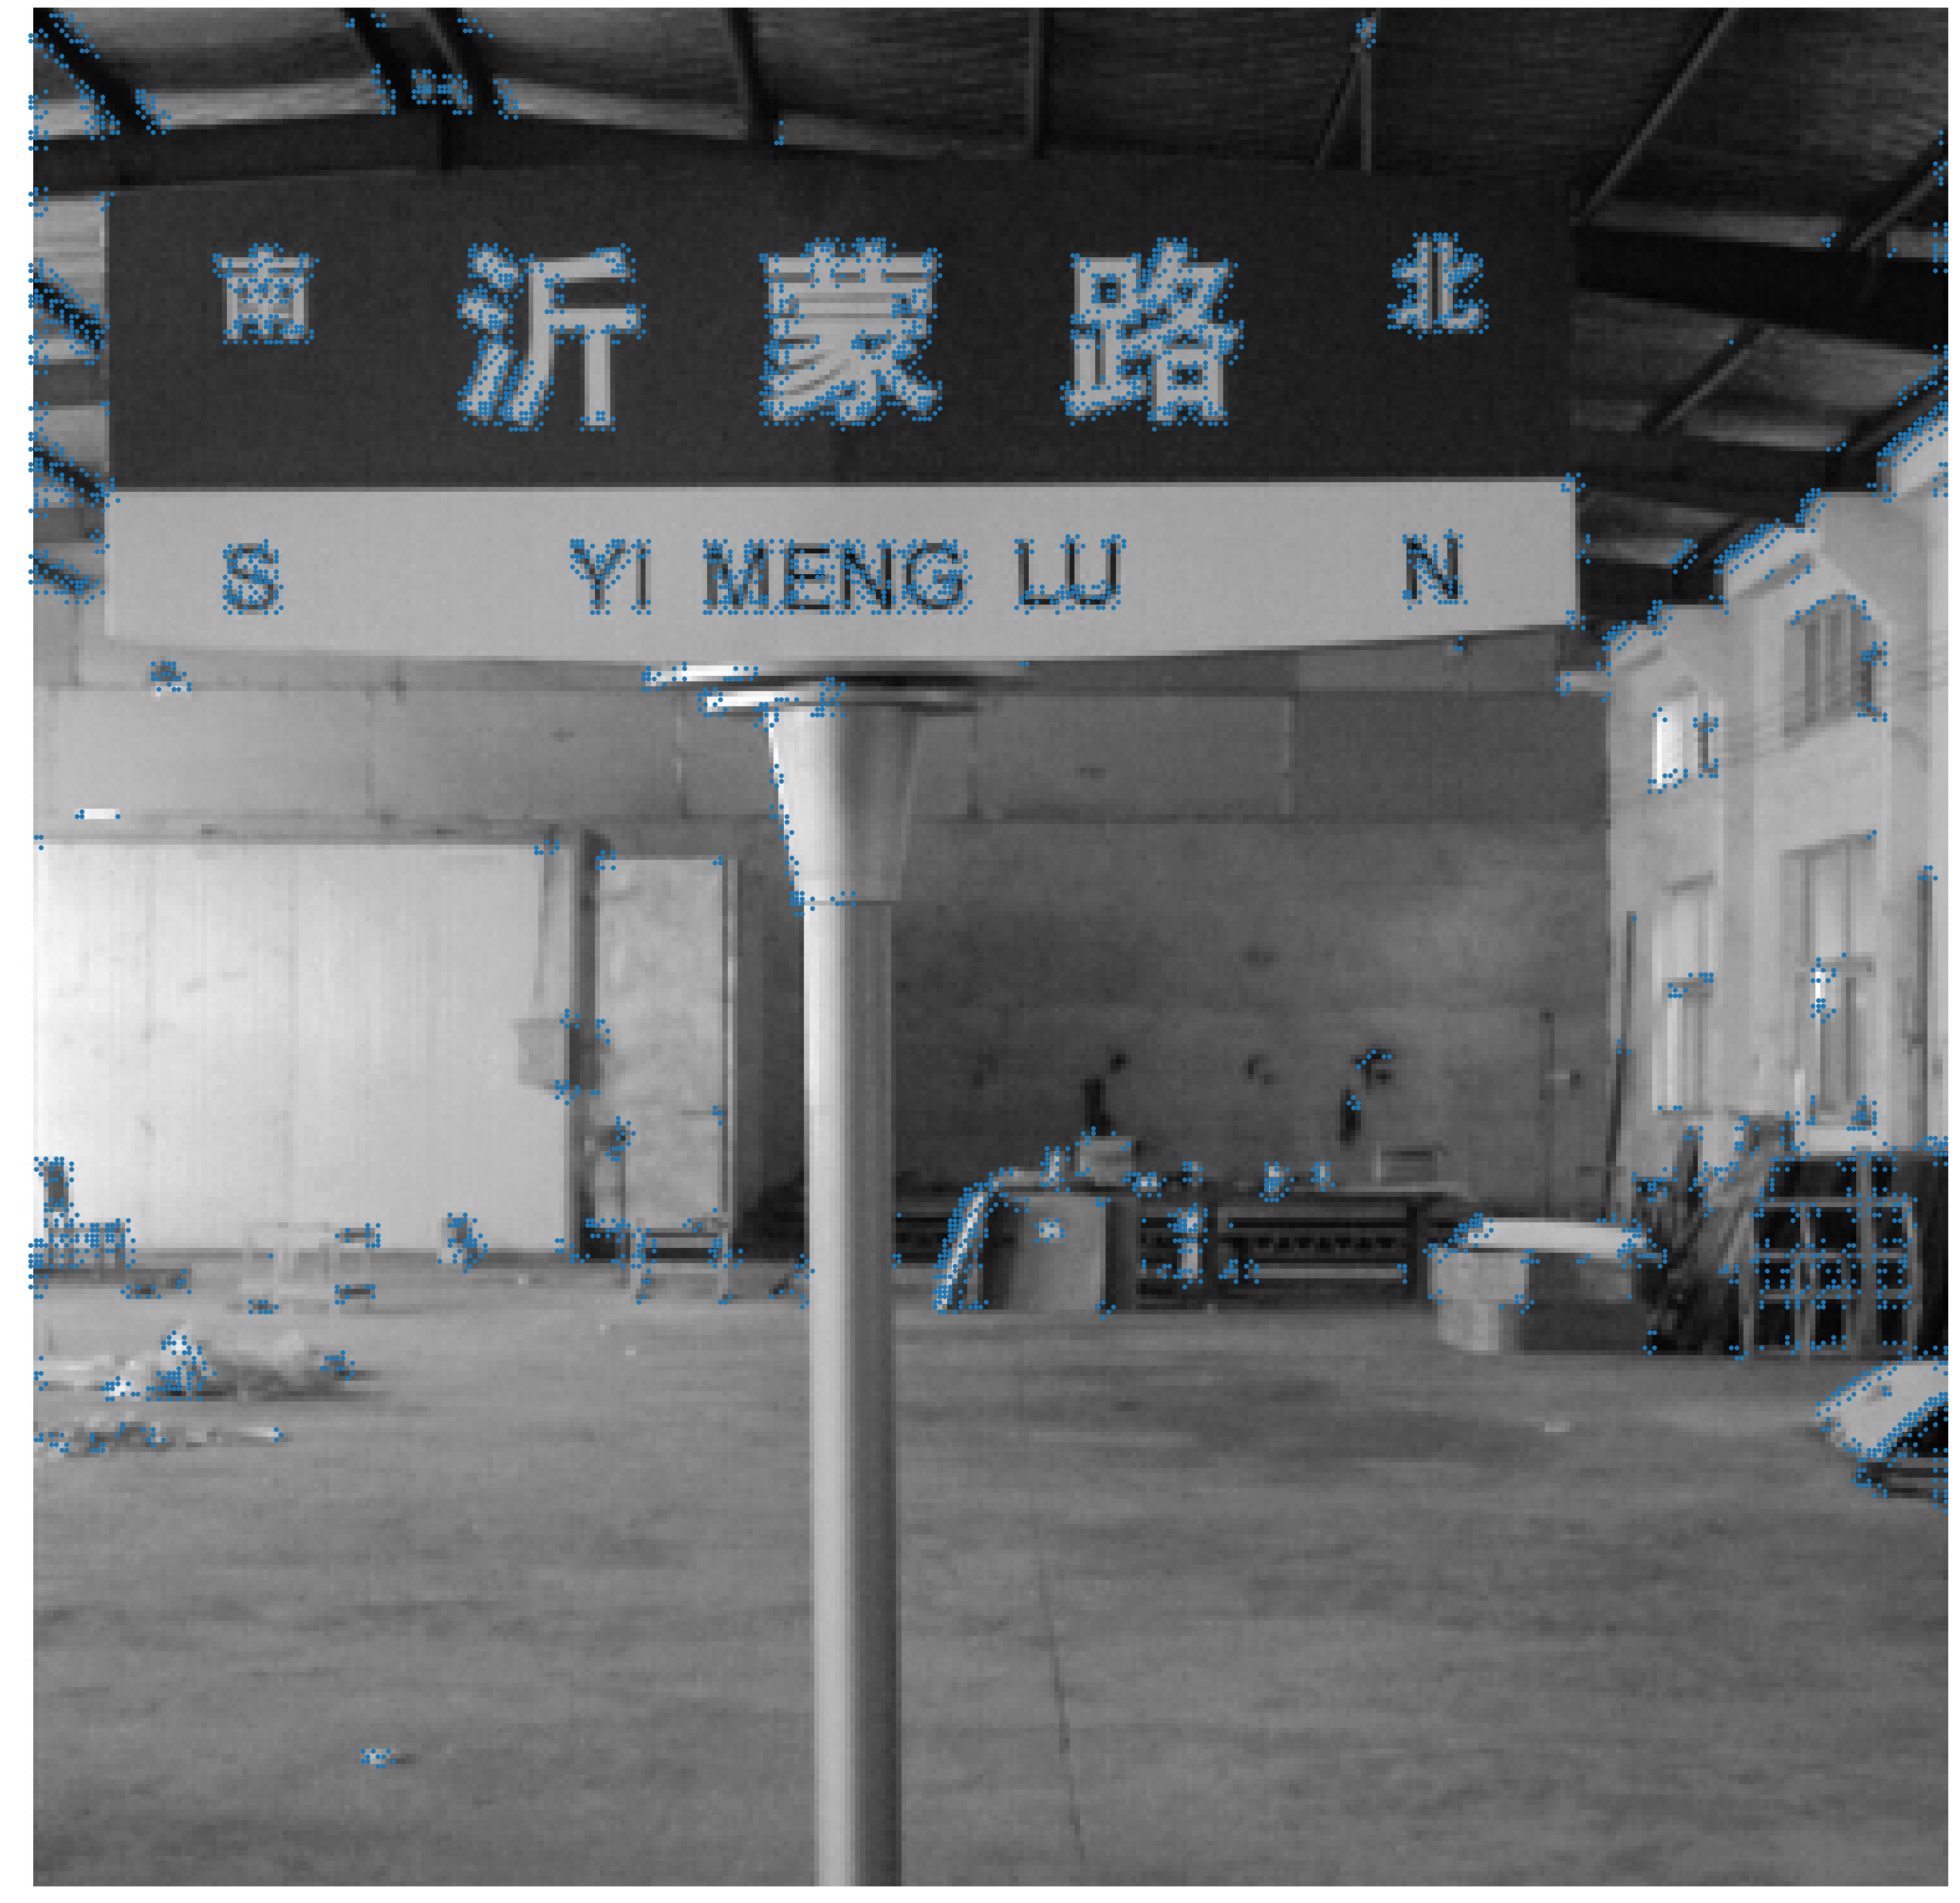

In [56]:
im = array(Image.open('./../resources/2018-03-06/26.jpg').convert('L'))
# 参数的设定还需要待定，如果对于花哨的图片，目前参数不适用 如 12.jpg
harrisim = compute_harris_response(im,0.8)
filtered_coords = get_harris_points(harrisim, min_dist=1, threshold=0.05)
plot_harris_points(im, filtered_coords)

In [31]:
help(filters.gaussian_filter)

Help on function gaussian_filter in module scipy.ndimage.filters:

gaussian_filter(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    Multidimensional Gaussian filter.
    
    Parameters
    ----------
    input : array_like
        Input array to filter.
    sigma : scalar or sequence of scalars
        Standard deviation for Gaussian kernel. The standard
        deviations of the Gaussian filter are given for each axis as a
        sequence, or as a single number, in which case it is equal for
        all axes.
    order : int or sequence of ints, optional
        The order of the filter along each axis is given as a sequence
        of integers, or as a single number.  An order of 0 corresponds
        to convolution with a Gaussian kernel. A positive order
        corresponds to convolution with that derivative of a Gaussian.
    output : array, optional
        The `output` parameter passes an array in which to store the
        filter output. Output 

In [48]:
((harrisim > 0.1) * 1).nonzero()

(array([  0,   0,   0, ..., 367, 367, 367]),
 array([  0,   1,   2, ..., 375, 376, 377]))

In [53]:
help(nonzero)

Help on function nonzero in module numpy.core.fromnumeric:

nonzero(a)
    Return the indices of the elements that are non-zero.
    
    Returns a tuple of arrays, one for each dimension of `a`,
    containing the indices of the non-zero elements in that
    dimension. The values in `a` are always tested and returned in
    row-major, C-style order. The corresponding non-zero
    values can be obtained with::
    
        a[nonzero(a)]
    
    To group the indices by element, rather than dimension, use::
    
        transpose(nonzero(a))
    
    The result of this is always a 2-D array, with a row for
    each non-zero element.
    
    Parameters
    ----------
    a : array_like
        Input array.
    
    Returns
    -------
    tuple_of_arrays : tuple
        Indices of elements that are non-zero.
    
    See Also
    --------
    flatnonzero :
        Return indices that are non-zero in the flattened version of the input
        array.
    ndarray.nonzero :
        Equivale

In [54]:
help(argsort)

Help on function argsort in module numpy.core.fromnumeric:

argsort(a, axis=-1, kind='quicksort', order=None)
    Returns the indices that would sort an array.
    
    Perform an indirect sort along the given axis using the algorithm specified
    by the `kind` keyword. It returns an array of indices of the same shape as
    `a` that index data along the given axis in sorted order.
    
    Parameters
    ----------
    a : array_like
        Array to sort.
    axis : int or None, optional
        Axis along which to sort.  The default is -1 (the last axis). If None,
        the flattened array is used.
    kind : {'quicksort', 'mergesort', 'heapsort'}, optional
        Sorting algorithm.
    order : str or list of str, optional
        When `a` is an array with fields defined, this argument specifies
        which fields to compare first, second, etc.  A single field can
        be specified as a string, and not all fields need be specified,
        but unspecified fields will still 